In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, RecurrentNetwork, QuantileLoss
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [2]:
raw_data = pd.read_csv('spotData.csv')

In [3]:
raw_data.head()

,Region,instanceType,major,minor,Type,OS,Price,2021-11-15 16:40:32.509429,2021-11-15 17:10:28.898009,2021-11-15 17:40:32.852006,...,2021-12-05 12:16:37.733092,2021-12-05 12:46:49.867893,2021-12-05 13:16:39.878279,2021-12-05 13:46:38.752443,2021-12-05 14:16:38.833343,2021-12-05 14:46:45.473251,2021-12-05 15:16:39.445467,2021-12-05 15:46:40.172507,2021-12-05 16:16:47.807489,2021-12-05 16:46:39.137754
0,us-east,a1.medium,a1,medium,generalCurrentGen,linux,0.0084,0.0084,0.0084,0.0084,...,0.0084,0.0084,0.0084,0.0084,0.0084,0.0084,0.0084,0.0084,0.0084,0.0084
1,us-east,a1.medium,a1,medium,generalCurrentGen,mswin,N/A*,N/A*,N/A*,N/A*,...,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*
2,us-east,a1.large,a1,large,generalCurrentGen,linux,0.0217,0.0218,0.0218,0.0218,...,0.0187,0.0187,0.0187,0.0187,0.0187,0.0187,0.0187,0.0187,0.0187,0.0187
3,us-east,a1.large,a1,large,generalCurrentGen,mswin,N/A*,N/A*,N/A*,N/A*,...,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*,N/A*
4,us-east,a1.xlarge,a1,xlarge,generalCurrentGen,linux,0.0341,0.0341,0.0341,0.0341,...,0.0361,0.0361,0.0361,0.0362,0.0362,0.0362,0.0362,0.0362,0.0362,0.0362


In [4]:
# load data: this is pandas dataframe with at least a column for
# * the target (what you want to predict)
# * the timeseries ID (which should be a unique string to identify each timeseries)
# * the time of the observation (which should be a monotonically increasing integer)
TRANSFORM_DATA = True
if TRANSFORM_DATA:
    raw_data = pd.read_csv('spotData.csv').head(16)
    date_columns = [x for x in raw_data.columns if x.startswith('2021')]
    not_date_columns = [x for x in raw_data.columns if not x.startswith('2021')]
    raw_data = raw_data.melt(id_vars=not_date_columns, value_vars=date_columns, var_name='date', value_name='blabla').drop(columns=['blabla'])
    raw_data.to_csv('data.csv', index=False)
else:
    raw_data = pd.read_csv('data.csv')

In [5]:
data = raw_data.astype({
    'Region': 'category',
    'instanceType': 'category',
    'major': 'category',
    'minor': 'category',
    'Type': 'category',
    'OS': 'category',
    'date': 'datetime64'
})
dates = {v: k for k, v in enumerate(data['date'].drop_duplicates().sort_values())}
data['time_idx'] = data['date'].apply(lambda x: dates[x])
# data['Price'] = pd.to_numeric(raw_data['Price'], errors='coerce').fillna(-1)
data['Price'] = pd.to_numeric(raw_data['Price'], errors='coerce')

In [6]:
data[data['date'] <= '2021-12-03']

,Region,instanceType,major,minor,Type,OS,Price,date,time_idx
0,us-east,a1.medium,a1,medium,generalCurrentGen,linux,0.0084,2021-11-15 16:40:32.509429,0
1,us-east,a1.medium,a1,medium,generalCurrentGen,mswin,NaN,2021-11-15 16:40:32.509429,0
2,us-east,a1.large,a1,large,generalCurrentGen,linux,0.0217,2021-11-15 16:40:32.509429,0
3,us-east,a1.large,a1,large,generalCurrentGen,mswin,NaN,2021-11-15 16:40:32.509429,0
4,us-east,a1.xlarge,a1,xlarge,generalCurrentGen,linux,0.0341,2021-11-15 16:40:32.509429,0
...,...,...,...,...,...,...,...,...,...
11819,us-east,a1.metal,a1,metal,generalCurrentGen,mswin,NaN,2021-12-02 23:46:42.905937,738
11820,us-east,t2.micro,t2,micro,generalCurrentGen,linux,0.0035,2021-12-02 23:46:42.905937,738
11821,us-east,t2.micro,t2,micro,generalCurrentGen,mswin,0.0081,2021-12-02 23:46:42.905937,738
11822,us-east,t2.small,t2,small,generalCurrentGen,linux,0.0069,2021-12-02 23:46:42.905937,738


In [7]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 36
max_prediction_length = 6
training_cutoff = '2021-12-03'  # day for cutoff

training = TimeSeriesDataSet(
    data[data['date'] <= training_cutoff],#data[lambda x: x.date <= training_cutoff],
    time_idx='time_idx',  # column name of time of observation
    target='Price',  # column name of target to predict
    group_ids=['Region', 'OS', 'instanceType'],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=['major', 'minor', 'Type'],
    # static_reals=[ ... ],
    # covariates known and unknown in the future to inform prediction
    # time_varying_known_categoricals=[ ... ],
    time_varying_known_reals=['time_idx'],
    # time_varying_unknown_categoricals=[ ... ],
    time_varying_unknown_reals=['Price'],
    target_normalizer=NaNLabelEncoder(add_nan=True),
)

/home/liranringel/miniconda3/envs/butterfly/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:119: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [8]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/home/liranringel/miniconda3/envs/butterfly/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:119: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [9]:
import warnings
warnings.filterwarnings("ignore")
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 60.6k


Set SLURM handle signals.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/liranringel/spot/lr_find_temp_model_fd00765a-8c65-423a-944c-d715039644da.ckpt


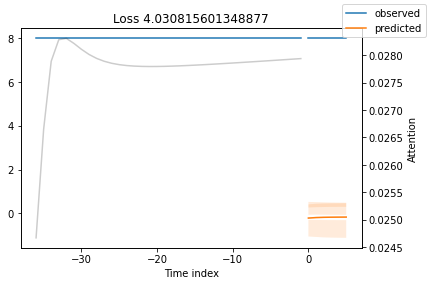

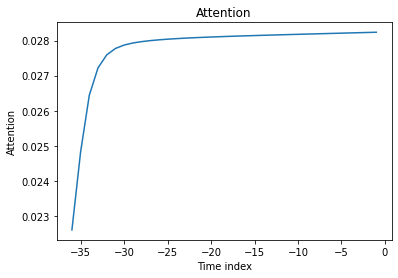

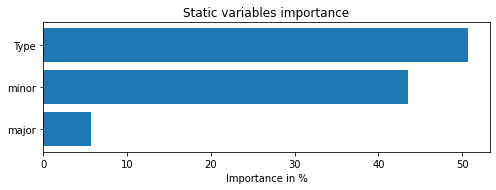

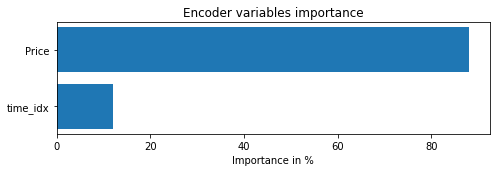

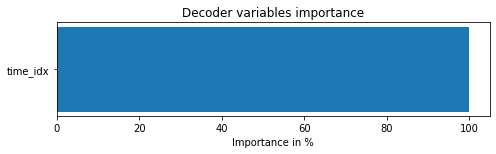

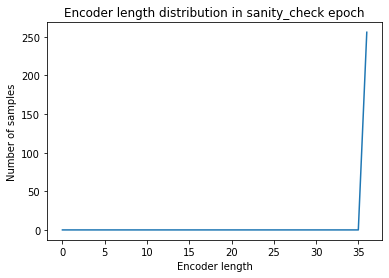

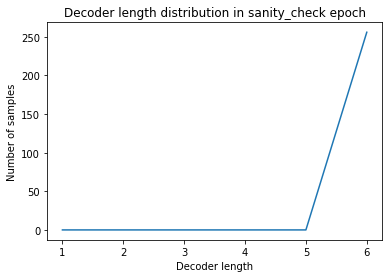

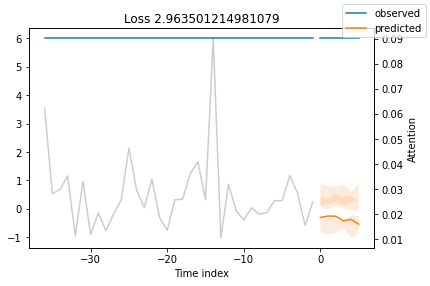

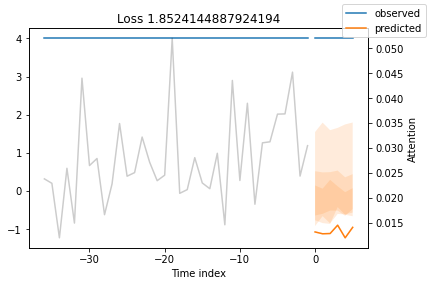

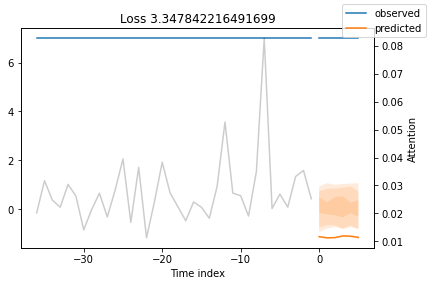

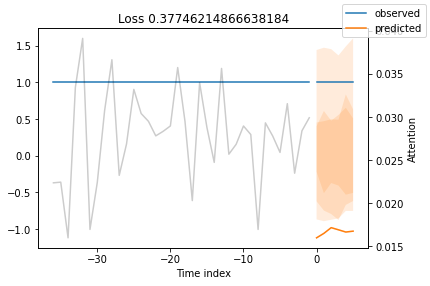

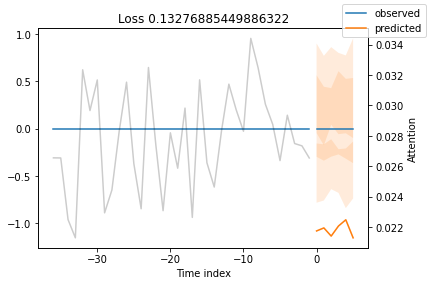

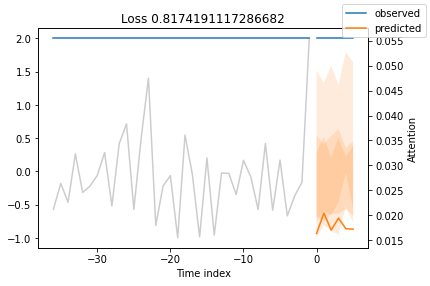

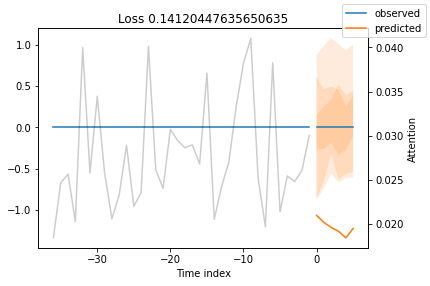

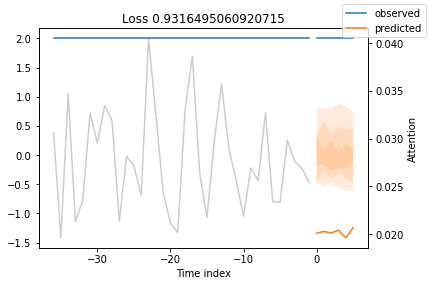

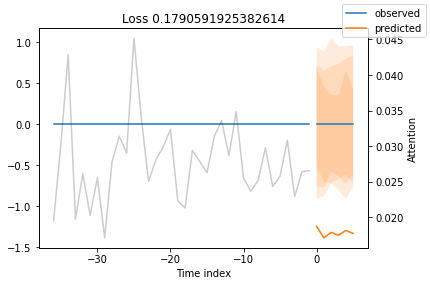

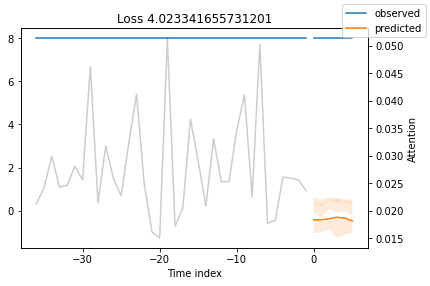

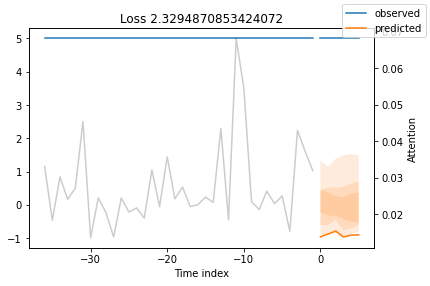

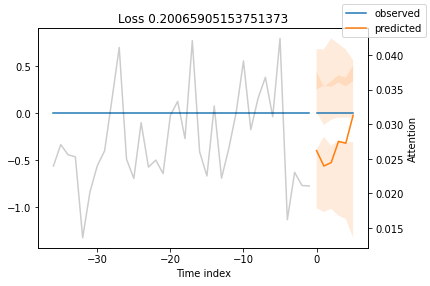

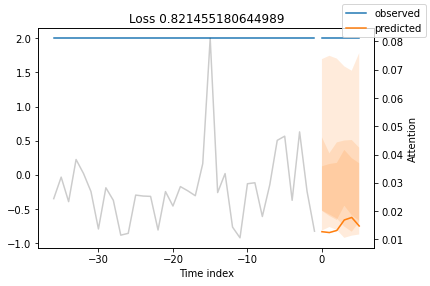

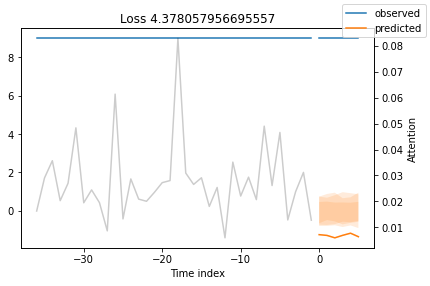

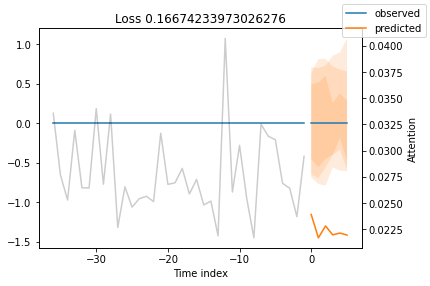

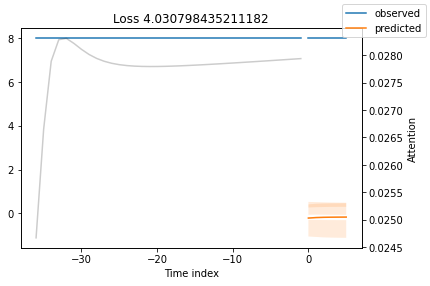

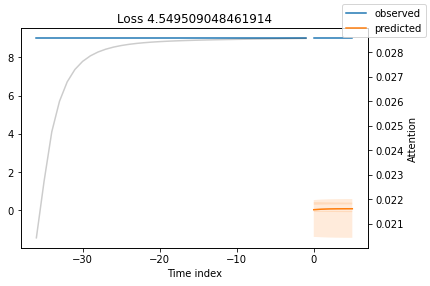

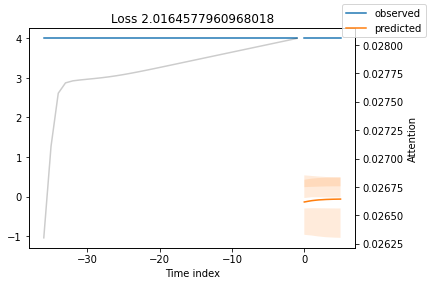

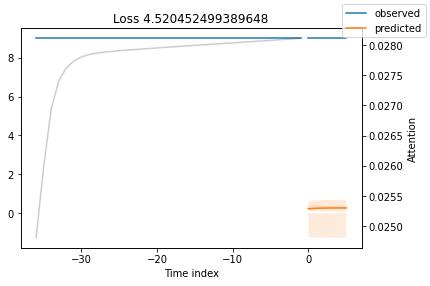

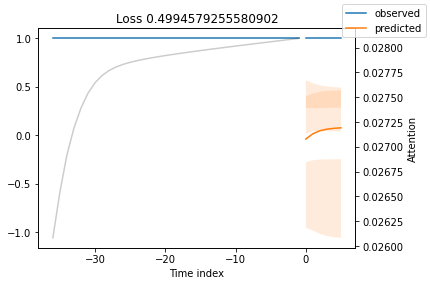

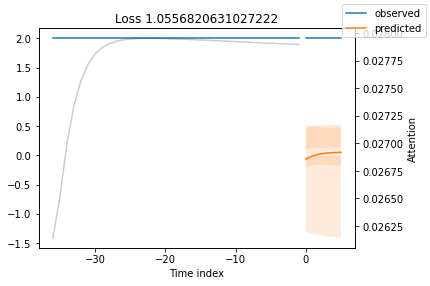

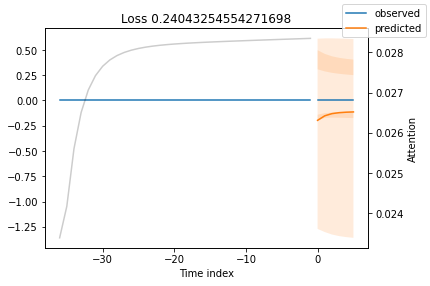

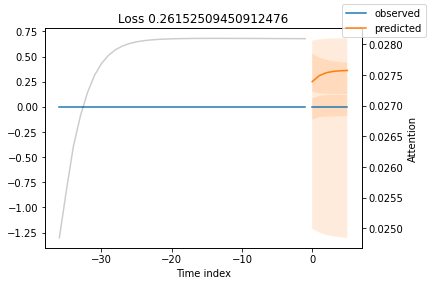

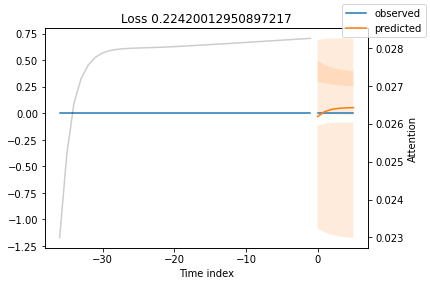

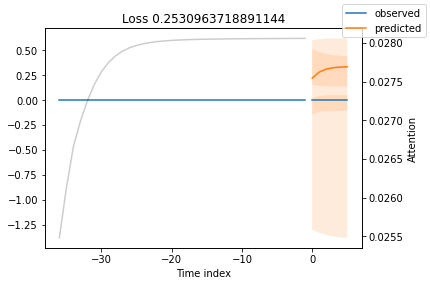

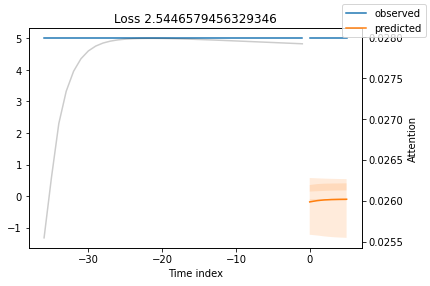

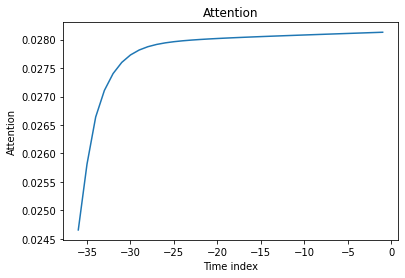

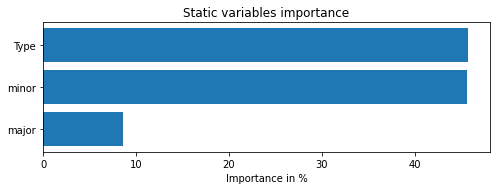

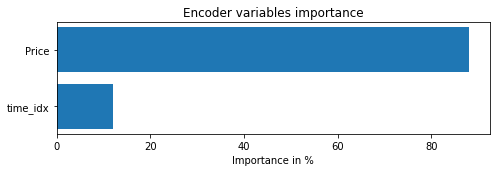

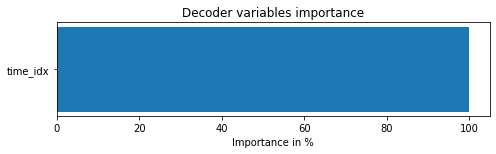

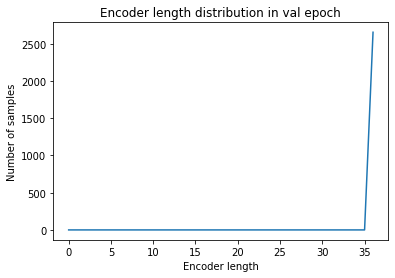

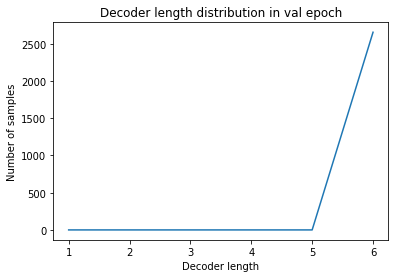

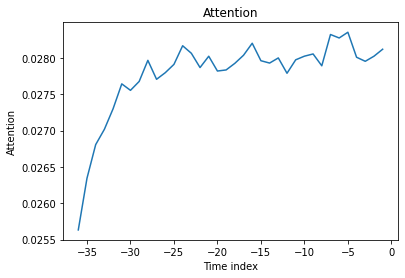

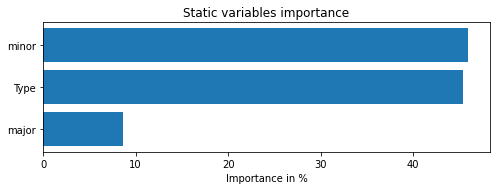

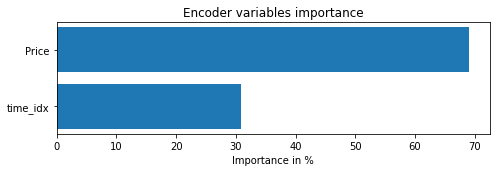

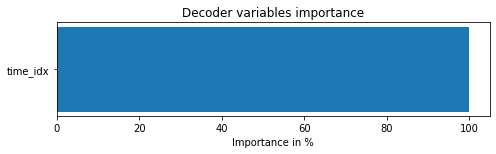

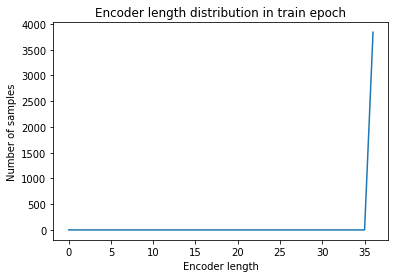

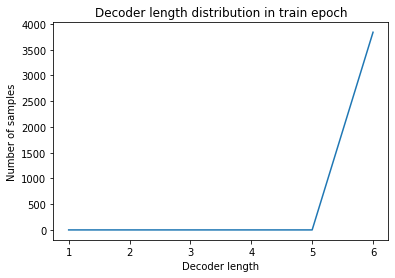

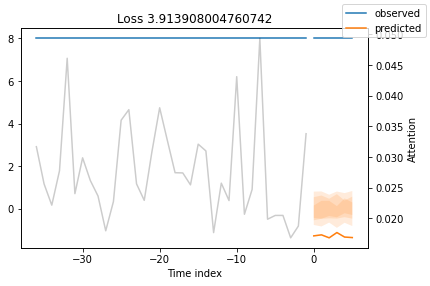

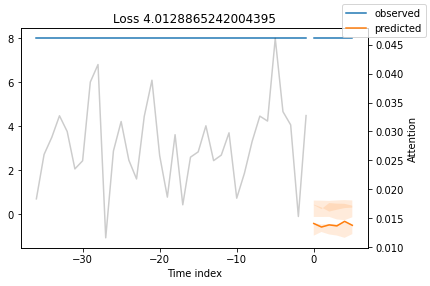

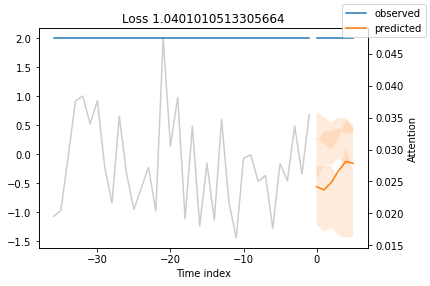

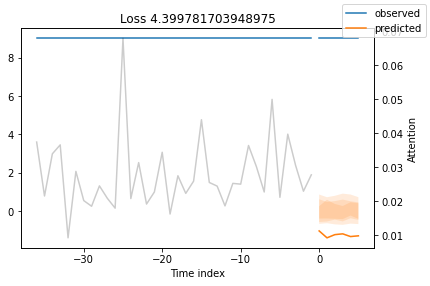

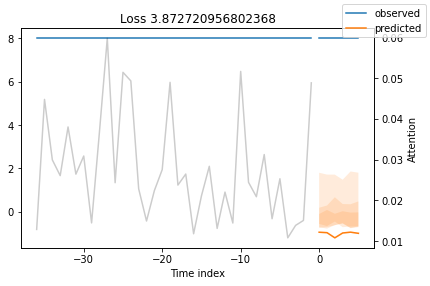

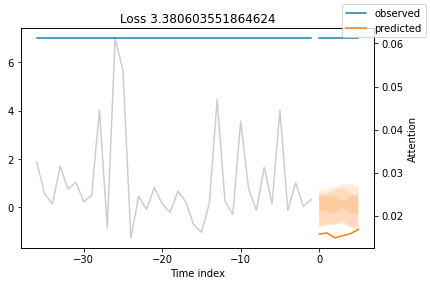

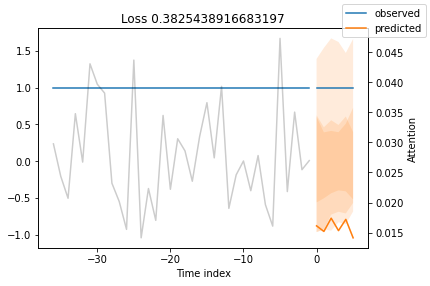

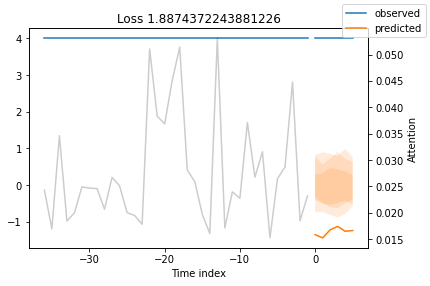

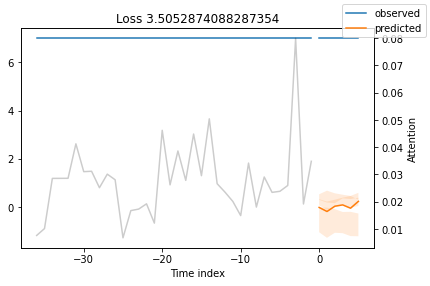

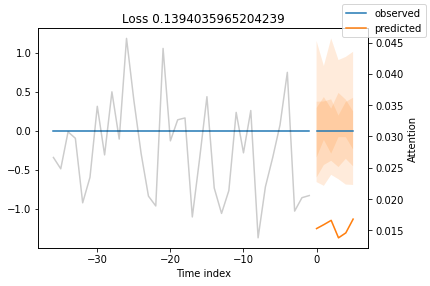

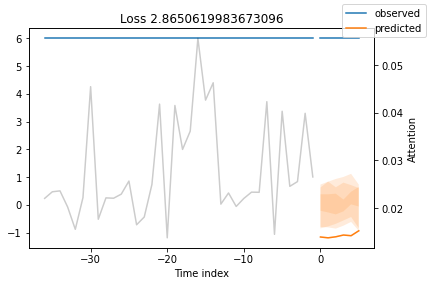

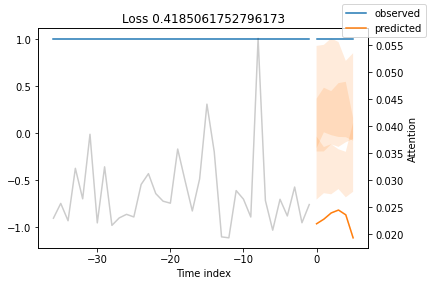

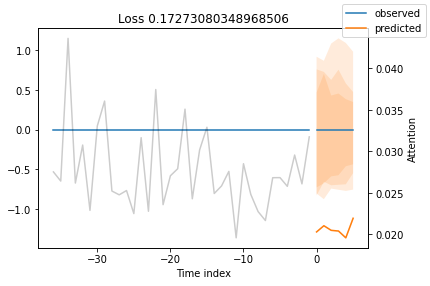

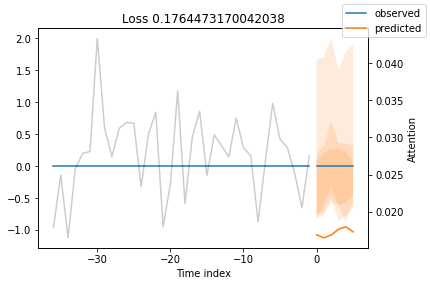

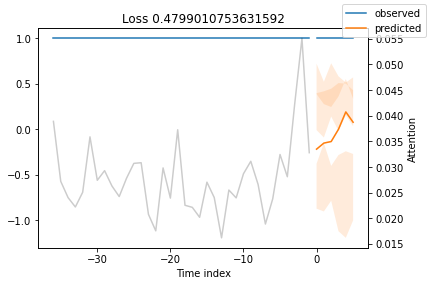

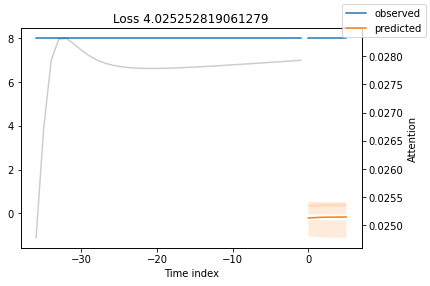

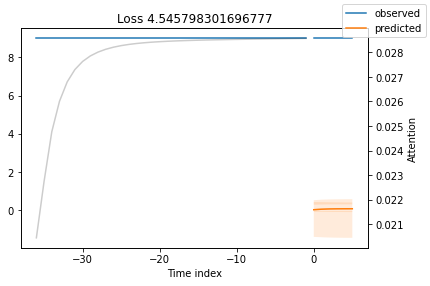

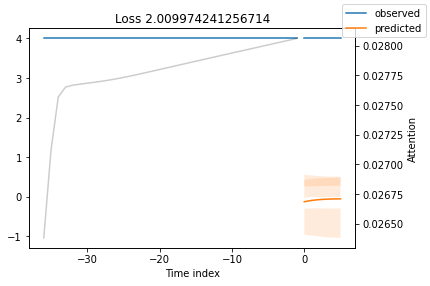

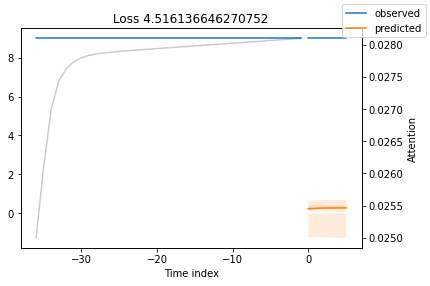

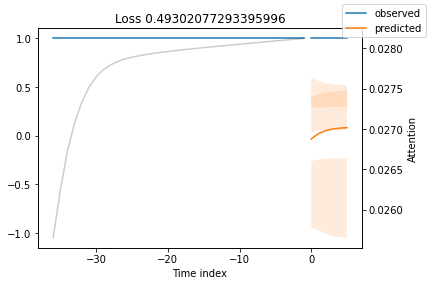

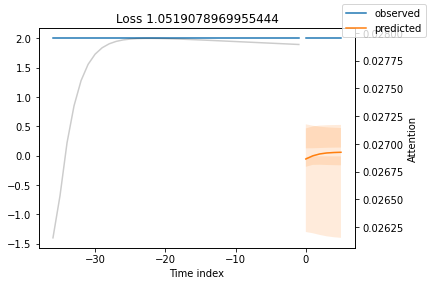

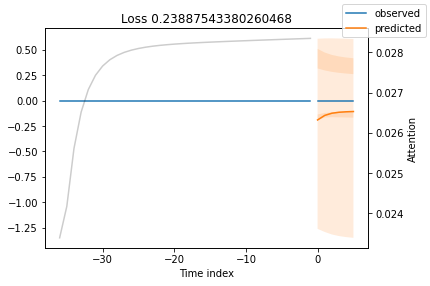

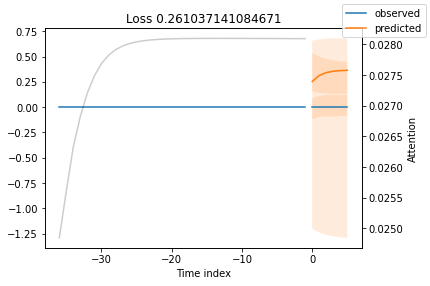

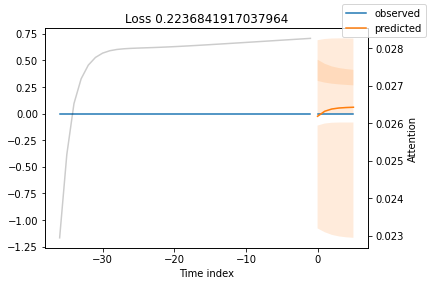

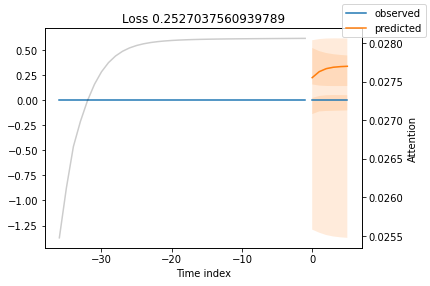

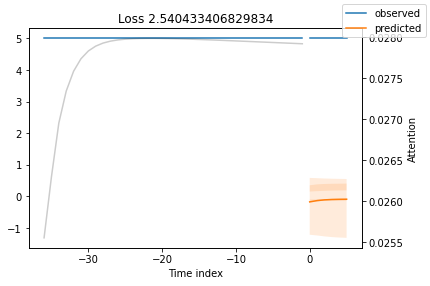

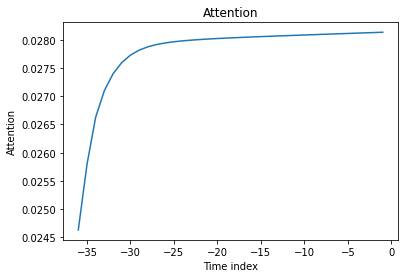

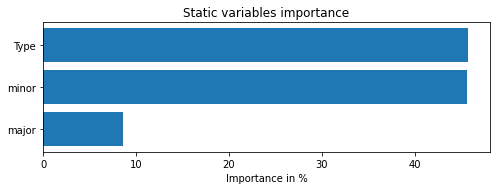

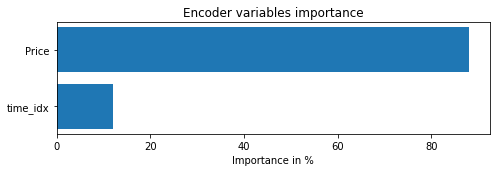

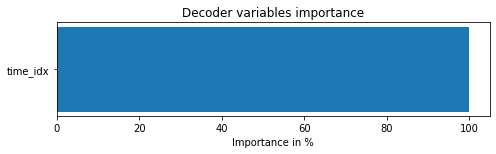

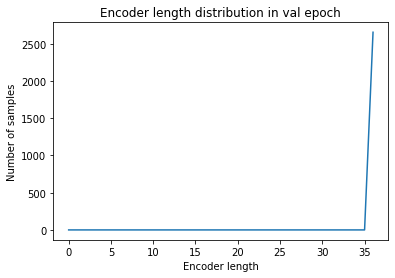

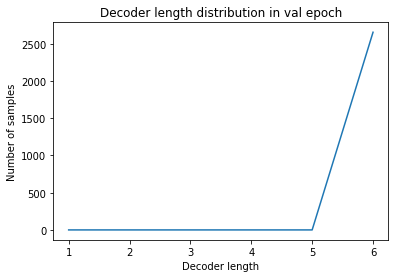

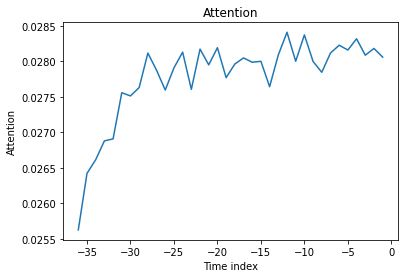

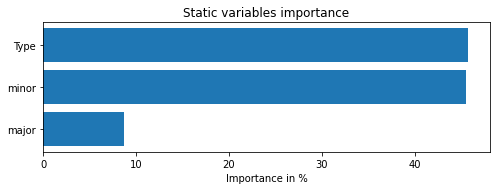

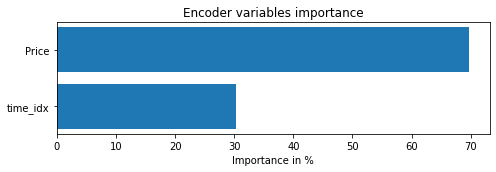

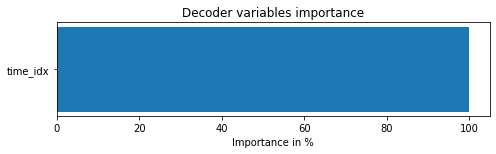

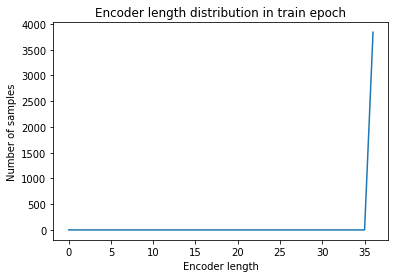

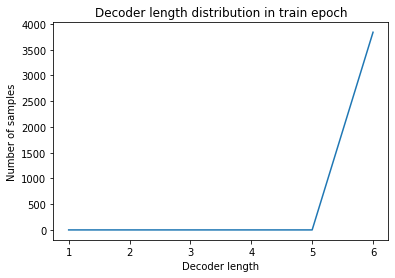

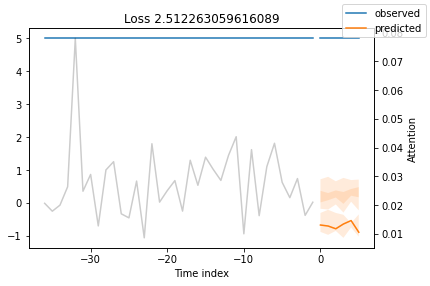

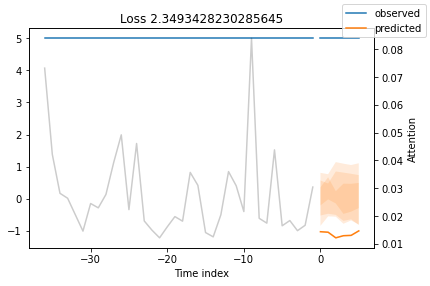

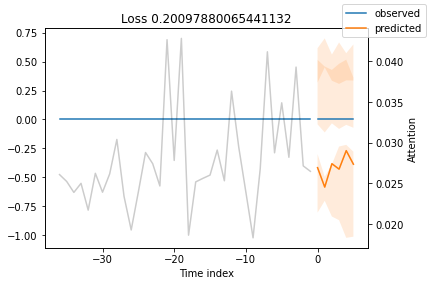

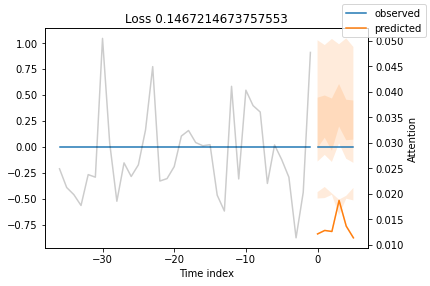

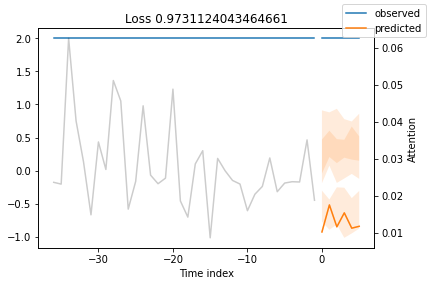

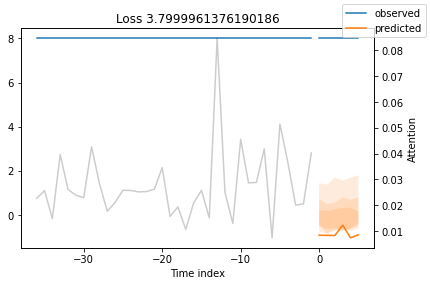

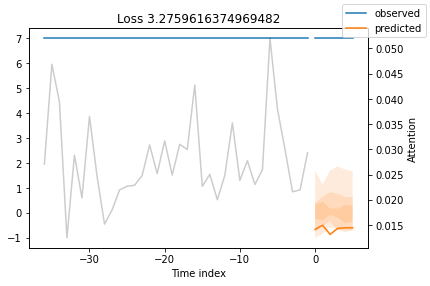

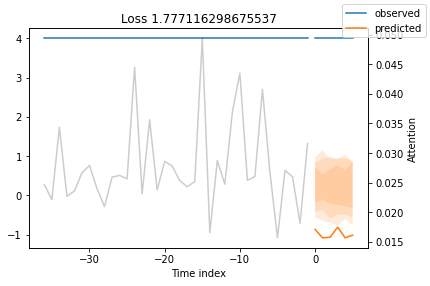

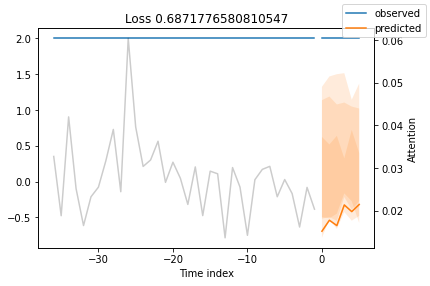

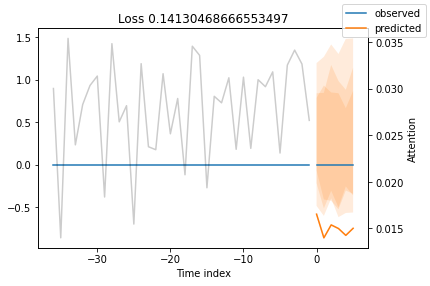

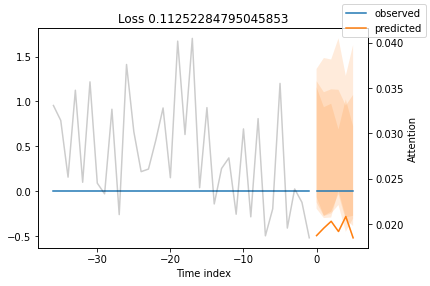

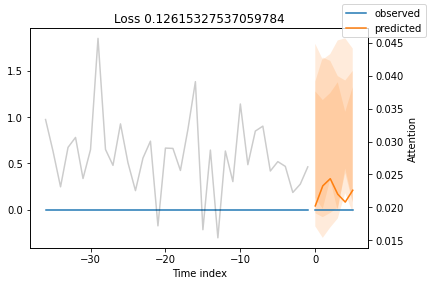

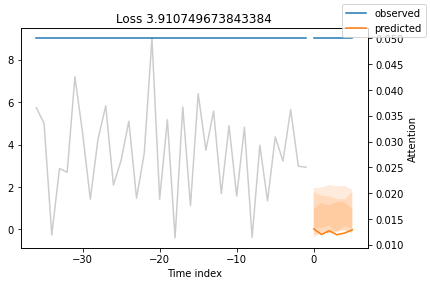

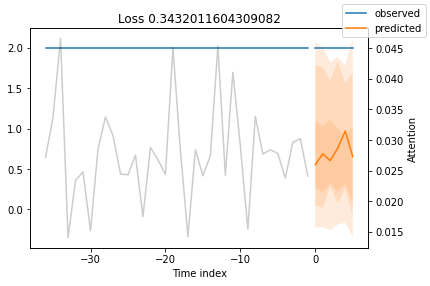

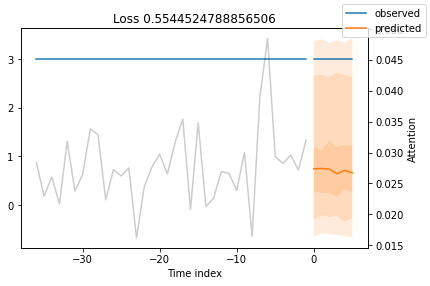

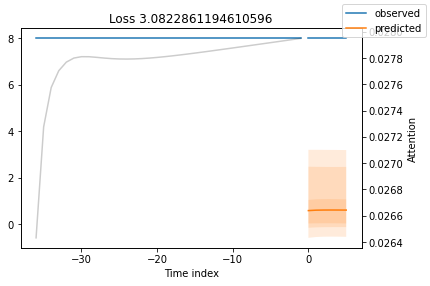

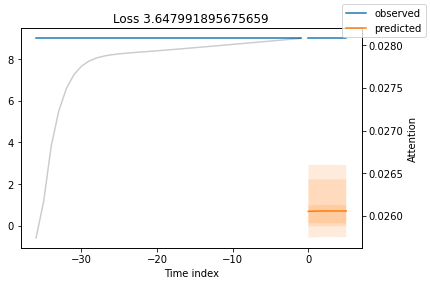

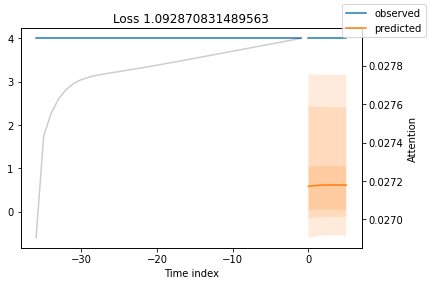

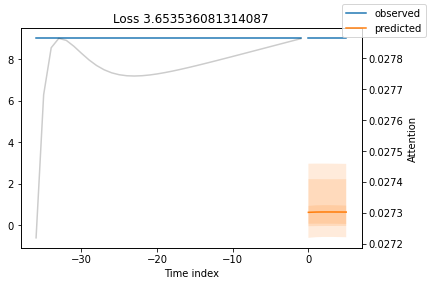

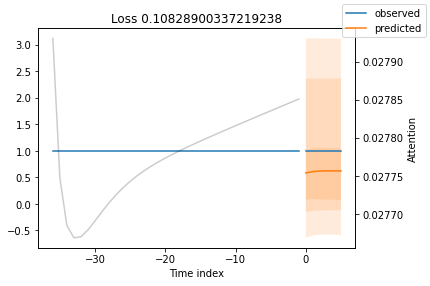

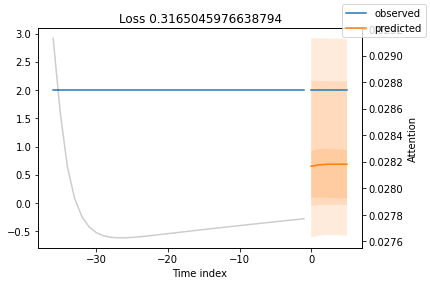

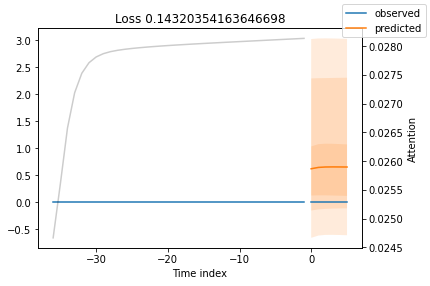

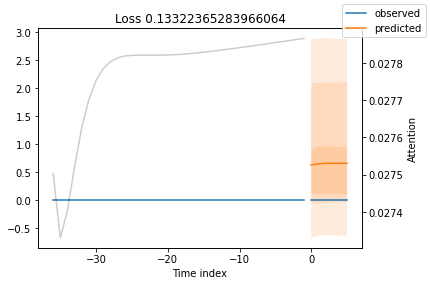

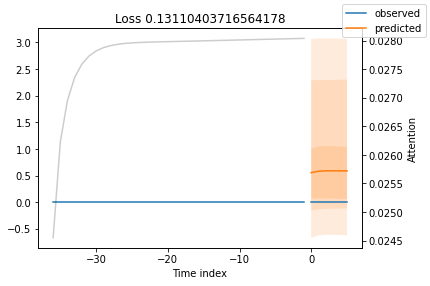

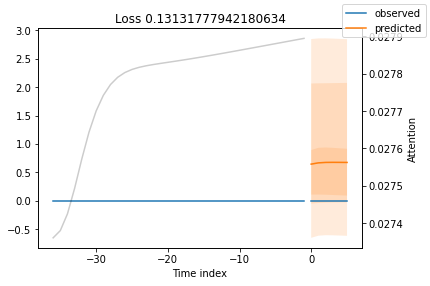

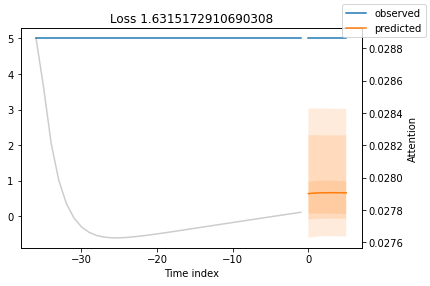

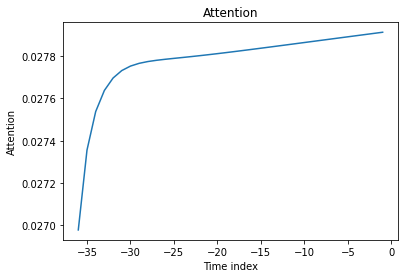

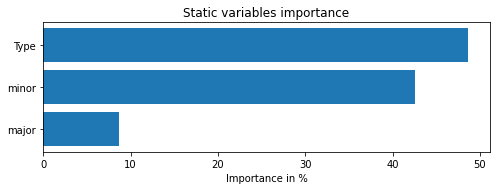

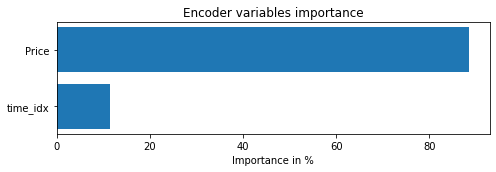

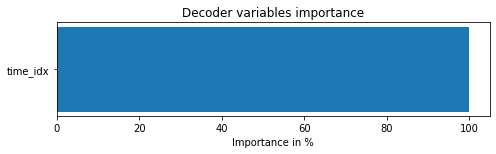

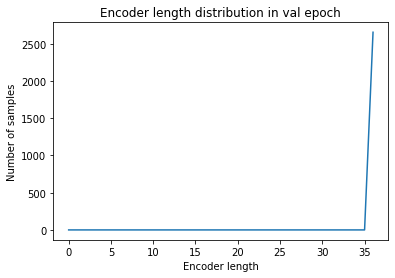

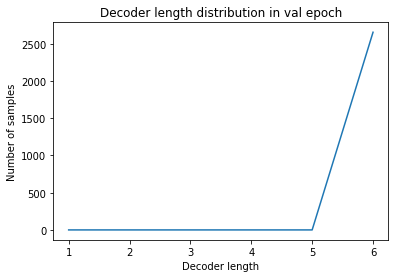

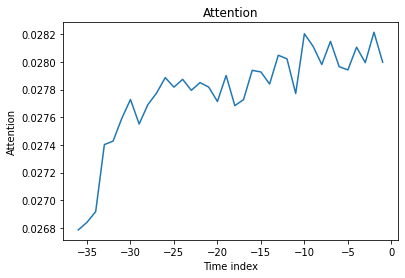

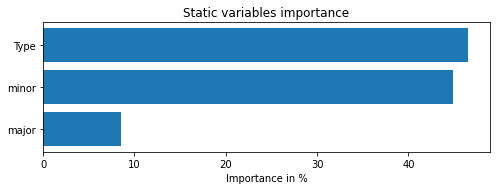

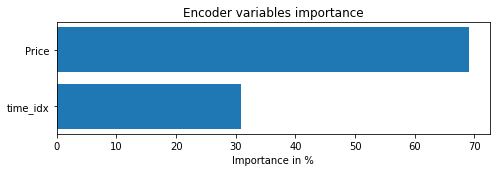

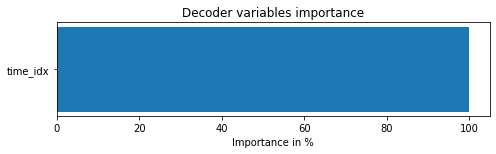

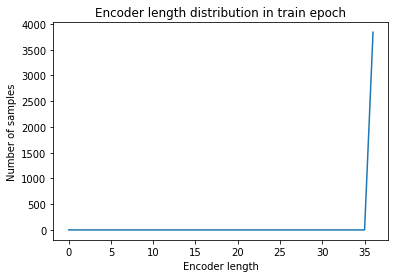

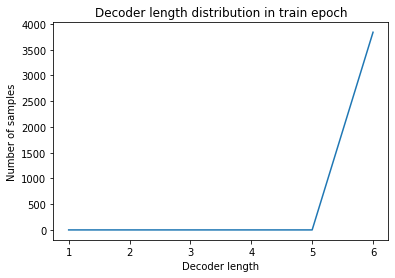

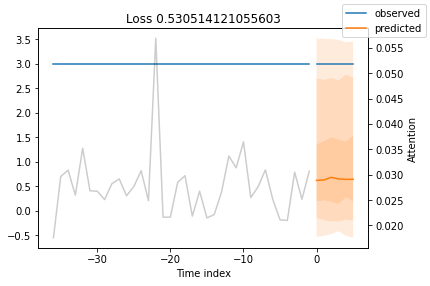

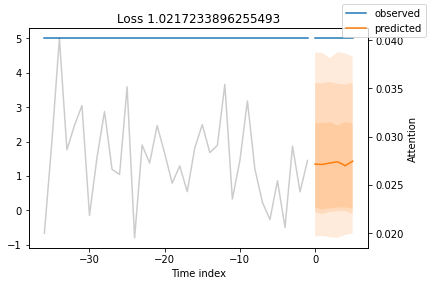

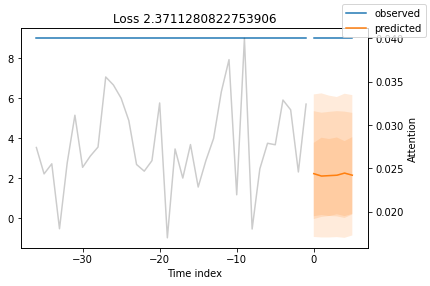

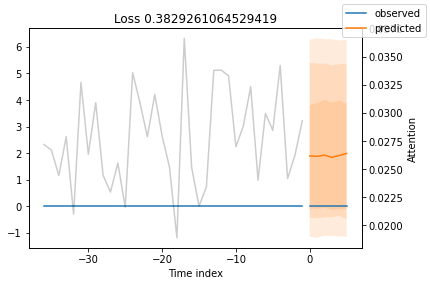

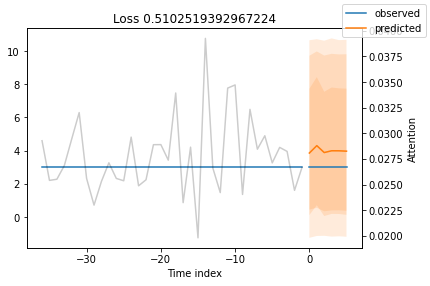

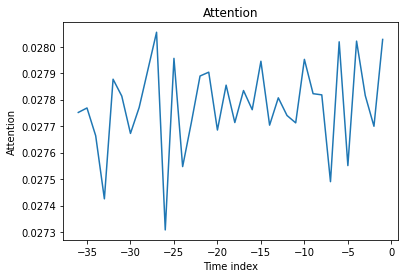

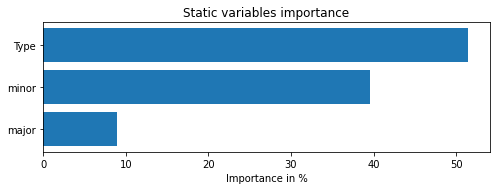

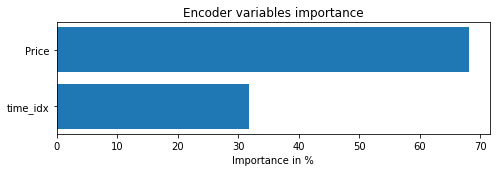

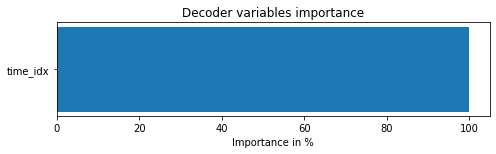

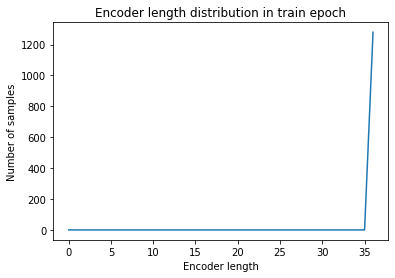

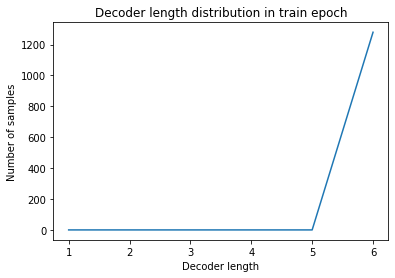

In [10]:
# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find the optimal learning rate
res = trainer.tuner.lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

suggested learning rate: 0.15067333621094023


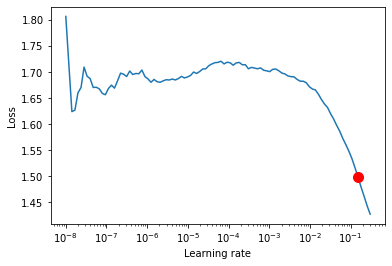

In [11]:
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [12]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 43    
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 363   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [18]:
trainer.validate(tft, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 0.09723298996686935,
 'val_MAPE': 602099.3125,
 'val_RMSE': 0.10887572169303894,
 'val_SMAPE': 0.7870880365371704,
 'val_loss': 0.029290098696947098}
--------------------------------------------------------------------------------


[{'val_loss': 0.029290098696947098,
  'val_SMAPE': 0.7870880365371704,
  'val_MAE': 0.09723298996686935,
  'val_RMSE': 0.10887572169303894,
  'val_MAPE': 602099.3125}]